In [ ]:
!pip install yfinance pandas numpy scikit-learn matplotlib mplcursors


In [1]:
!pip install xgboost


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Data berhasil diambil!

📊 Evaluasi Random Forest:
MAE  = 117.86
RMSE = 156.99
R²   = 0.2469

📊 Evaluasi XGBoost:
MAE  = 202.71
RMSE = 239.71
R²   = -0.7557


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the futu

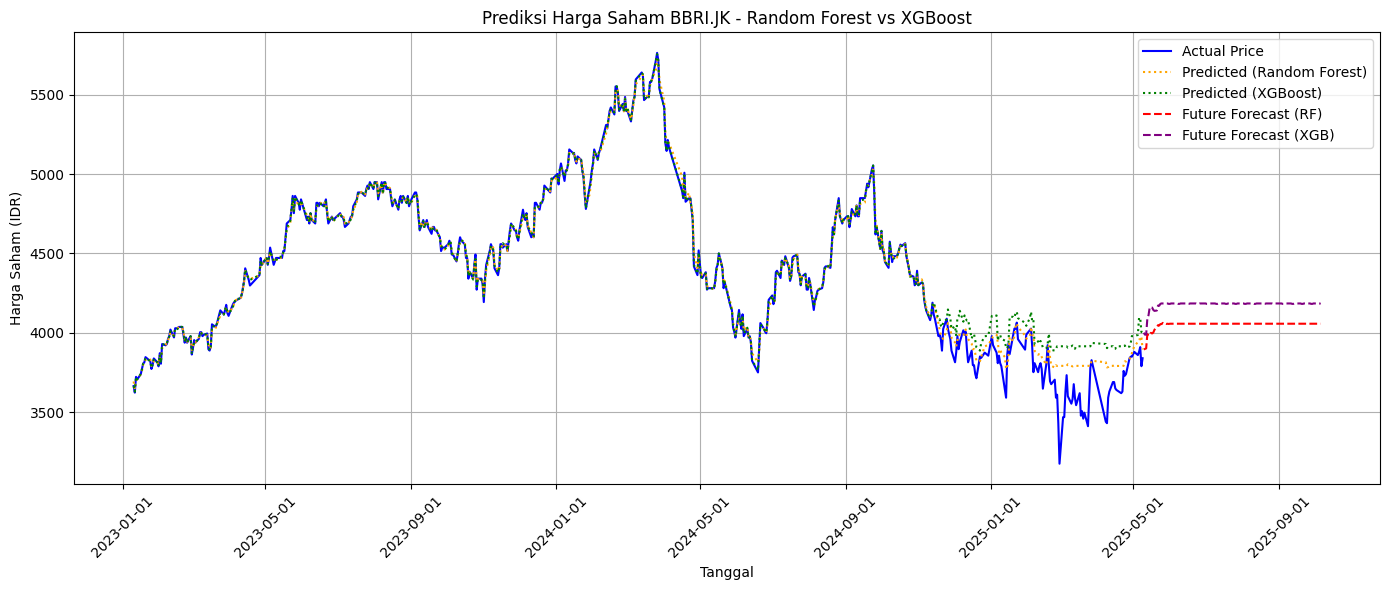

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta
import xgboost as xgb

# 1️⃣ Ambil data saham
ticker = "BBRI.JK"
start_date = "2023-01-01"
end_date = "2025-05-10"

data = yf.download(ticker, start=start_date, end=end_date).dropna()

if data.empty:
    print("❌ Data tidak tersedia.")
    exit()
else:
    print("✅ Data berhasil diambil!")

# 2️⃣ Siapkan fitur tambahan
data.reset_index(inplace=True)
data['Day'] = (data['Date'] - data['Date'].min()).dt.days
data['Lag_1'] = data['Close'].shift(1)
data['Lag_3'] = data['Close'].shift(3)
data['MA_3'] = data['Close'].rolling(3).mean()
data['MA_7'] = data['Close'].rolling(7).mean()
data.dropna(inplace=True)

# 3️⃣ Definisikan fitur & target
features = ['Day', 'Lag_1', 'Lag_3', 'MA_3', 'MA_7']
X = data[features]
X.columns = [col[0].strip() if isinstance(col, tuple) else col.strip() for col in X.columns]
y = data['Close']

# 4️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5️⃣ Random Forest
model_rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)

# 🔍 Evaluasi RF
y_pred_rf = model_rf.predict(X_test)
print("\n📊 Evaluasi Random Forest:")
print(f"MAE  = {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"R²   = {r2_score(y_test, y_pred_rf):.4f}")

# 6️⃣ XGBoost
model_xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train)

# 🔍 Evaluasi XGB
y_pred_xgb = model_xgb.predict(X_test)
print("\n📊 Evaluasi XGBoost:")
print(f"MAE  = {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"R²   = {r2_score(y_test, y_pred_xgb):.4f}")

# 7️⃣ Prediksi masa depan - Random Forest
future_dates_rf = []
future_preds_rf = []
last_known = data.iloc[-1]

for i in range(1, 151):
    future_day = last_known['Day'] + i
    date = data['Date'].max() + timedelta(days=i)

    lag_1 = future_preds_rf[-1] if len(future_preds_rf) >= 1 else last_known['Lag_1']
    lag_3 = future_preds_rf[-3] if len(future_preds_rf) >= 3 else last_known['Lag_3']
    ma_3 = np.mean(future_preds_rf[-3:]) if len(future_preds_rf) >= 3 else last_known['MA_3']
    ma_7 = np.mean(future_preds_rf[-7:]) if len(future_preds_rf) >= 7 else last_known['MA_7']

    row = pd.DataFrame([[future_day, lag_1, lag_3, ma_3, ma_7]], columns=features)
    row.columns = row.columns.str.strip()

    pred = model_rf.predict(row)[0]
    future_preds_rf.append(pred)
    future_dates_rf.append(date)

# 8️⃣ Prediksi masa depan - XGBoost
future_dates_xgb = []
future_preds_xgb = []
last_known_xgb = data.iloc[-1]

for i in range(1, 151):
    future_day = last_known_xgb['Day'] + i
    date = data['Date'].max() + timedelta(days=i)

    lag_1 = future_preds_xgb[-1] if len(future_preds_xgb) >= 1 else last_known_xgb['Lag_1']
    lag_3 = future_preds_xgb[-3] if len(future_preds_xgb) >= 3 else last_known_xgb['Lag_3']
    ma_3 = np.mean(future_preds_xgb[-3:]) if len(future_preds_xgb) >= 3 else last_known_xgb['MA_3']
    ma_7 = np.mean(future_preds_xgb[-7:]) if len(future_preds_xgb) >= 7 else last_known_xgb['MA_7']

    row_xgb = pd.DataFrame([[future_day, lag_1, lag_3, ma_3, ma_7]], columns=features).astype(np.float32)
    row_xgb.columns = row_xgb.columns.str.strip()

    if row_xgb.isnull().values.any():
        pred_xgb = future_preds_xgb[-1] if future_preds_xgb else last_known_xgb['Close']
    else:
        pred_xgb = model_xgb.predict(row_xgb)[0]

    future_preds_xgb.append(pred_xgb)
    future_dates_xgb.append(date)

# 9️⃣ Visualisasi
plt.figure(figsize=(14, 6))

plt.plot(data['Date'], data['Close'], label='Actual Price', color='blue')
plt.plot(data['Date'], model_rf.predict(X), label='Predicted (Random Forest)', linestyle='dotted', color='orange')
plt.plot(data['Date'], model_xgb.predict(X), label='Predicted (XGBoost)', linestyle='dotted', color='green')
plt.plot(future_dates_rf, future_preds_rf, label='Future Forecast (RF)', linestyle='dashed', color='red')
plt.plot(future_dates_xgb, future_preds_xgb, label='Future Forecast (XGB)', linestyle='dashed', color='purple')

plt.xlabel("Tanggal")
plt.ylabel("Harga Saham (IDR)")
plt.title(f"Prediksi Harga Saham {ticker} - Random Forest vs XGBoost")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
